In [1]:
using LinearAlgebra
using Distributions 
using Random
using Plots

1. Generate some data $(\mathbf{X}, \vec{y})$ to fit our Gaussian process to. 

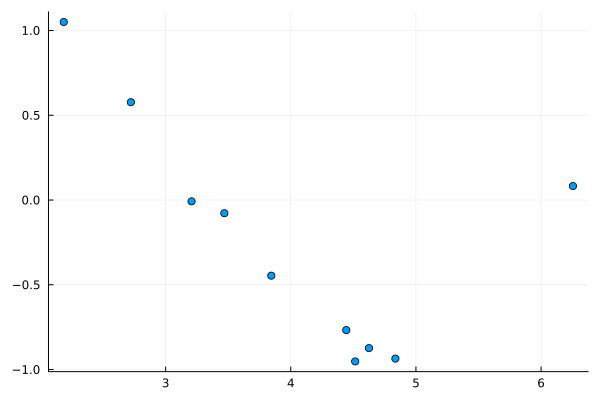

In [2]:
# function to sample from: 
hyperparams = (0.3, 1.08, 0.00005)
# hyperparams = (1.0, 1.0, 0.1)
# hyperparams = (3.0, 1.16, 0.89)


σₙ² = (hyperparams[3])^2
σf² = (hyperparams[2])^2
ℓ = hyperparams[1]

#σₙ² = (0.00005)^2
#σf² = (1.08)^2
#ℓ= 0.3

y(x) = sin(x) + 0.25*rand()

#X = 0:0.5:2π
X = 2π*rand(10)
yvec = y.(X)
X = X'


plot(X', yvec, seriestype=:scatter, label="")

2. Compute Kernel matrix on sample data. We will use RBF kernel given by 
\begin{equation}
k(\vec{x},\vec{x}') = \sigma_f^2 \exp\left(-\frac{1}{2\ell^2}(\vec{x}-\vec{x}')^2\right) + \sigma_n^2 \delta_{\vec{x},\vec{x}'}
\end{equation}

In [3]:
# first define how copute elemnt i,j 
function rbf_ij(X₁::AbstractMatrix, X₂::AbstractMatrix, i::Int, j::Int)
    return σf²*exp(-(X₁[:,i] .- X₂[:,j])' * (X₁[:,i] .- X₂[:,j])/(2ℓ^2))
end

rbf_ij(X,X, 1, 2)

1.6315002393789335e-5

In [4]:
function RBF(X₁::AbstractMatrix, X₂::AbstractMatrix)
    (d₁,n₁) = size(X₁)
    (d₂,n₂) = size(X₂)
    # we need to require d₁ == d₂
    K = zeros(n₁, n₂)
 
    @inline for j ∈ 1:n₂, i ∈ 1:n₁
        K[i,j] = rbf_ij(X₁, X₂, i, j)
    end
    
    return K 
end

K = RBF(X,X) + σₙ²*I

10×10 Matrix{Float64}:
 1.1664       1.6315e-5    1.42631e-8   …  4.57386e-7   9.23765e-31
 1.6315e-5    1.1664       0.495577        0.91063      1.93767e-11
 1.42631e-8   0.495577     1.1664          0.971459     8.30078e-8
 2.25353e-19  3.6381e-5    0.00599239      0.000700442  0.0524919
 4.61341e-23  4.63803e-7   0.00023966      1.65141e-5   0.31578
 5.83655e-8   0.657818     1.1338       …  1.09057      2.05822e-8
 1.36187e-40  1.33486e-17  5.92592e-13     5.21241e-15  0.236234
 1.13076e-14  0.00494962   0.158849        0.0395442    0.00106851
 4.57386e-7   0.91063      0.971459        1.1664       2.15172e-9
 9.23765e-31  1.93767e-11  8.30078e-8      2.15172e-9   1.1664

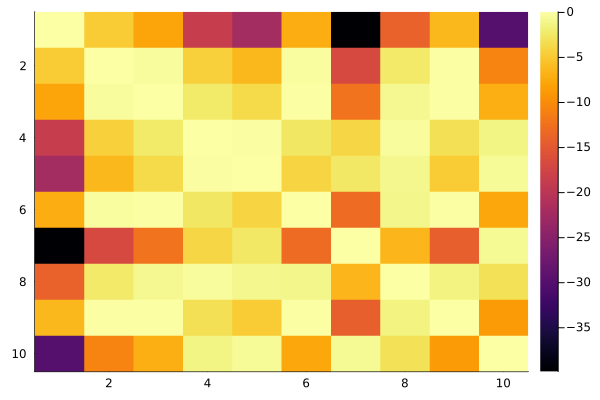

In [5]:
# visualize the covariance matrix
# heatmap(log10.(K), yflip=true)
heatmap(log10.(K), yflip=true)

In [6]:
L = cholesky(K).L

10×10 LowerTriangular{Float64, Matrix{Float64}}:
 1.08          ⋅            ⋅           …   ⋅           ⋅          ⋅ 
 1.51065e-5   1.08          ⋅               ⋅           ⋅          ⋅ 
 1.32066e-8   0.458868     0.977671         ⋅           ⋅          ⋅ 
 2.08661e-19  3.36862e-5   0.00611344       ⋅           ⋅          ⋅ 
 4.27168e-23  4.29447e-7   0.000244932      ⋅           ⋅          ⋅ 
 5.40422e-8   0.60909      0.873816     …   ⋅           ⋅          ⋅ 
 1.26099e-40  1.23598e-17  6.0612e-13       ⋅           ⋅          ⋅ 
 1.047e-14    0.00458298   0.160326        0.860051     ⋅          ⋅ 
 4.23506e-7   0.843176     0.597903        0.0221324   0.0638415   ⋅ 
 8.55338e-31  1.79414e-11  8.48952e-8      0.0982697  -0.0281519  0.990221

In [7]:
# compute expansion coefficients
α = (L')\(L\yvec)

size(α)

(10,)

In [8]:
# now we need a function to compue mean 
Xnew = (0:0.05:2π)'
Koldnew = RBF(X, Xnew)
ynew = Koldnew'*α

126-element Vector{Float64}:
  2.742066180618052e-12
  9.109385454670828e-12
  2.943313387250208e-11
  9.249541758449757e-11
  2.827093820771349e-10
  8.404202868069276e-10
  2.4299041800335757e-9
  6.833105113999023e-9
  1.868888583958579e-8
  4.971473271388232e-8
  1.2862436313038388e-7
  3.236665768964042e-7
  7.921529404088386e-7
  ⋮
 -0.14017586482879224
 -0.07857915553407273
 -0.034534457725638415
 -0.0029444855089711293
  0.020173051685654364
  0.03765395297236265
  0.05131913959389386
  0.062186294930938885
  0.07070359181525561
  0.07696988517645732
  0.08092184294397213
  0.08247859928532056

In [9]:
# compute the variance
vvec = L\Koldnew

Knewnew = RBF(Xnew, Xnew)
varnew =Knewnew .- vvec'*vvec; 

twostdevs = [2*sqrt(varnew[i,i]) for i ∈ 1:size(Xnew,2)]

126-element Vector{Float64}:
 2.16
 2.16
 2.16
 2.16
 2.16
 2.16
 2.16
 2.16
 2.1599999999999997
 2.1599999999999966
 2.1599999999999784
 2.159999999999863
 2.159999999999178
 ⋮
 2.1221493221346845
 2.094225232211851
 2.0478034928134368
 1.976490058296114
 1.8732662463201109
 1.7315655872399915
 1.5464837933757356
 1.3159352949148864
 1.041534457114087
 0.7290010754174152
 0.38796400764936945
 0.03114746268819057

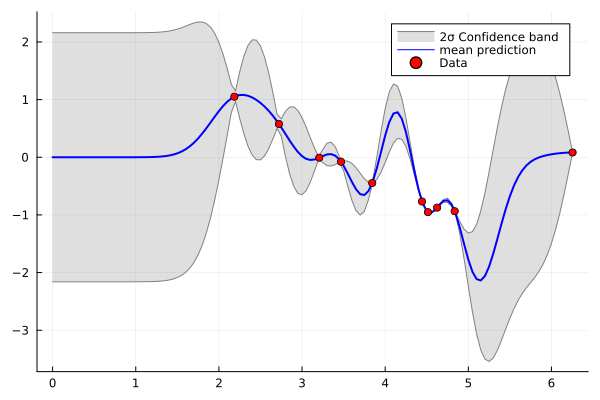

In [10]:
plot(Xnew', ynew .+ twostdevs, c=:gray, label="")
plot!(Xnew', ynew .- twostdevs, fillrange = ynew .+ twostdevs, fillalpha = 0.25, c = :gray, label = "2σ Confidence band")
plot!(Xnew', ynew, c=:blue, lw=2, label="mean prediction")
plot!(X', yvec, seriestype=:scatter, color=:red, label="Data")

In [11]:
savefig("gpr_demo.pdf")

In [12]:
savefig("gpr_demo.png")